# Best Models
Chan Wei Jian Ivan
1005924
Tom Manuel Opalla Piccio
1006293
Deshpande Sunny Nitin
1006336



In [1]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import pytz
import numpy as np
import os
import sys
import glob
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import re
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import ConcatDataset, TensorDataset

In [2]:
# Define the directory and base filename pattern
file_path_test = "data/test_data/cleaned_compiled_data_normalized.csv"

# Load and concatenate all parts
test_data = pd.read_csv(file_path_test)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.set_default_device(device)

g = torch.Generator(device=device)

cuda


In [4]:
def safe_sigmoid(x):
    # If all outputs are already in [0, 1], assume sigmoid already applied
    if x.min() >= 0 and x.max() <= 1:
        return x  # Already probabilities
    return torch.sigmoid(x)  # Assume logits

def evaluate_metrics(dataloader, model, device="cuda"):
    model.eval()
    model.to(device)
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in dataloader:
            # Convert from NumPy if needed
            if isinstance(inputs, np.ndarray):
                inputs = torch.tensor(inputs)
            if isinstance(targets, np.ndarray):
                targets = torch.tensor(targets)

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            
            probs = safe_sigmoid(outputs)
            preds = (probs > 0.5).int()

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    accuracy = (all_preds == all_targets).mean()
    precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)

    print("🔎 Evaluation Results for LSTM Model")
    print("====================================")
    print(f"✅ Accuracy : {accuracy:.2f}")
    print(f"🎯 Precision: {precision:.4f}")
    print(f"🔁 Recall   : {recall:.4f}")
    print(f"📊 F1 Score : {f1:.4f}")

    return accuracy, precision, recall, f1


In [5]:
from LSTM import LSTM_Dataset,LSTM_Module
LSTM_dataset = LSTM_Dataset(test_data)
LSTM_dataloader = DataLoader(LSTM_dataset, batch_size=64, shuffle=True, generator=g)

d:\Documents\Term 8\Deep Learning\Lightning_Risk_Prediction\LSTM\LSTM.py:48: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.compiled_df[col] = self.compiled_df[col].interpolate(limit_direction='both')


In [6]:
LSTM_model = LSTM_Module(
    hours_lookback=6,  # adjust if different
    input_dim=35,      # make sure it matches your input feature size
    hidden_dim=128,
    num_layers=1,
    dropout=0.2
)
LSTM_model_path = r'LSTM/LSTM.pth'
LSTM_model.load_state_dict(torch.load(LSTM_model_path, map_location=device))
LSTM_model.to(device)
LSTM_model.eval()

C:\Users\tomma\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


LSTM_Module(
  (lstm): LSTM(35, 128, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=5, bias=True)
  )
)

In [7]:
LSTM_results = evaluate_metrics(LSTM_dataloader,LSTM_model)

🔎 Evaluation Results for LSTM Model
✅ Accuracy : 0.93
🎯 Precision: 0.4831
🔁 Recall   : 0.1989
📊 F1 Score : 0.2627


In [8]:
chosen_stations = ['S104', 'S107', 'S109', 'S115', 'S116', 'S43', 'S50']
pixel_coords = [(4, 11, 'S109'),
 (2, 7, 'S50'),
 (1, 16, 'S107'),
 (2, 13, 'S43'),
 (0, 0, 'S115'),
 (0, 6, 'S116'),
 (8, 8, 'S104')]


In [9]:
from CNN_RNN import CNN_RNN_Dataset, CNN_RNN_Module
CNN_RNN_dataset = CNN_RNN_Dataset(test_data,pixel_coords, reject_zeros=False)
CNN_RNN_dataloader = DataLoader(CNN_RNN_dataset, batch_size=64, shuffle=True, generator=g)
CNN_RNN_model = CNN_RNN_Module()
CNN_RNN_model_path = r'CNN_RNN/CNN_RNN.pth'
CNN_RNN_model.load_state_dict(torch.load(CNN_RNN_model_path, map_location=device))
CNN_RNN_model.to(device)
CNN_RNN_model.eval()


CNN_RNN_Module(
  (conv1): Conv2d(5, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (rnn): RNN(8960, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [10]:
CNN_RNN_results = evaluate_metrics(CNN_RNN_dataloader,CNN_RNN_model)

🔎 Evaluation Results for LSTM Model
✅ Accuracy : 0.94
🎯 Precision: 0.5661
🔁 Recall   : 0.3467
📊 F1 Score : 0.4005


In [11]:
from deep_CNN_RNN import deep_CNN_RNN_Dataset, deep_CNN_RNN_Module
deep_CNN_RNN_dataset = deep_CNN_RNN_Dataset(test_data, reject_zeros=False)
deep_CNN_RNN_dataloader = DataLoader(deep_CNN_RNN_dataset, batch_size=64, shuffle=True, generator=g)
deep_CNN_RNN_model = deep_CNN_RNN_Module()
deep_CNN_RNN_model_path = r'deep_CNN_RNN/deep_CNN_RNN.pth'
deep_CNN_RNN_model.load_state_dict(torch.load(deep_CNN_RNN_model_path, map_location=device))
deep_CNN_RNN_model.to(device)
deep_CNN_RNN_model.eval()


deep_CNN_RNN_Module(
  (cnn): Sequential(
    (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
    (12): Dropout(p=0.3, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128

In [12]:
deep_CNN_RNN_results = evaluate_metrics(deep_CNN_RNN_dataloader,deep_CNN_RNN_model)

🔎 Evaluation Results for LSTM Model
✅ Accuracy : 0.93
🎯 Precision: 0.4540
🔁 Recall   : 0.3840
📊 F1 Score : 0.3980


In [13]:
from CNN_LSTM import CNN_LSTM_Dataset, CNN_LSTM_Module
CNN_LSTM_dataset = CNN_LSTM_Dataset(test_data, reject_zeros=False)
CNN_LSTM_dataloader = DataLoader(CNN_LSTM_dataset, batch_size=64, shuffle=True, generator=g)
CNN_LSTM_model = CNN_LSTM_Module()
CNN_LSTM_model_path = r'CNN_LSTM/CNN_LSTM.pth'
CNN_LSTM_model.load_state_dict(torch.load(CNN_LSTM_model_path, map_location=device))
CNN_LSTM_model.to(device)
CNN_LSTM_model.eval()


CNN_LSTM_Module(
  (conv1): Conv2d(5, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lstm): LSTM(8960, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [14]:
CNN_LSTM_results = evaluate_metrics(CNN_LSTM_dataloader,CNN_LSTM_model)

🔎 Evaluation Results for LSTM Model
✅ Accuracy : 0.94
🎯 Precision: 0.5563
🔁 Recall   : 0.3795
📊 F1 Score : 0.4389


In [15]:
from CNN_LSTM_HR import CNN_LSTM_HR_Dataset, CNN_LSTM_HR_Module
CNN_LSTM_HR_dataset = CNN_LSTM_HR_Dataset(test_data, pixel_coords=pixel_coords, reject_zeros=False)
CNN_LSTM_HR_dataloader = DataLoader(CNN_LSTM_HR_dataset, batch_size=64, shuffle=True, generator=g)
CNN_LSTM_HR_model = CNN_LSTM_HR_Module()
CNN_LSTM_HR_model_path = r'CNN_LSTM_HR/CNN_LSTM_HR.pth'
CNN_LSTM_HR_model.load_state_dict(torch.load(CNN_LSTM_HR_model_path, map_location=device))
CNN_LSTM_HR_model.to(device)
CNN_LSTM_HR_model.eval()

CNN_LSTM_HR_Module(
  (conv1): Conv2d(5, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lstm): LSTM(8960, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [16]:
CNN_LSTM_HR_results = evaluate_metrics(CNN_LSTM_HR_dataloader,CNN_LSTM_HR_model)

🔎 Evaluation Results for LSTM Model
✅ Accuracy : 0.90
🎯 Precision: 0.2976
🔁 Recall   : 0.2426
📊 F1 Score : 0.2614


In [17]:
from CNN_GRU import CNN_GRU_Dataset, CNN_GRU_Module
CNN_GRU_dataset = CNN_GRU_Dataset(test_data,reject_zeros=False)
CNN_GRU_dataloader = DataLoader(CNN_GRU_dataset, batch_size=64, shuffle=True, generator=g)
CNN_GRU_model = CNN_GRU_Module()
CNN_GRU_model_path = r'CNN_GRU/CNN_GRU.pth'
CNN_GRU_model.load_state_dict(torch.load(CNN_GRU_model_path, map_location=device))
CNN_GRU_model.to(device)
CNN_GRU_model.eval()


CNN_GRU_Module(
  (conv1): Conv2d(5, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (bn_in): BatchNorm1d(8960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru): GRU(8960, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=5, bias=True)
)

In [18]:
CNN_GRU_results = evaluate_metrics(CNN_GRU_dataloader,CNN_GRU_model)

🔎 Evaluation Results for LSTM Model
✅ Accuracy : 0.70
🎯 Precision: 0.2034
🔁 Recall   : 0.6321
📊 F1 Score : 0.2905


In [19]:
compiled_results = [LSTM_results,CNN_RNN_results,deep_CNN_RNN_results,CNN_LSTM_results,CNN_LSTM_HR_results,CNN_GRU_results]

In [20]:
def plot_accuracy_f1(compiled_results, model_names):
    metrics = ['Accuracy', 'F1 Score']
    n_models = len(compiled_results)

    # Extract only Accuracy and F1 from each result (index 0 and 3)
    selected_metrics = [(res[0], res[3]) for res in compiled_results]  # (Accuracy, F1)
    
    # Sort models by Accuracy
    sorted_data = sorted(zip(model_names, selected_metrics), key=lambda x: x[1][0], reverse=True)
    sorted_names, sorted_metrics = zip(*sorted_data)
    
    accuracy_scores, f1_scores = zip(*sorted_metrics)
    x = np.arange(n_models)
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy')
    bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

    # Add text on top of bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.4f}', ha='center', va='bottom', fontsize=9)

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.4f}', ha='center', va='bottom', fontsize=9)

    ax.set_ylabel('Score')
    ax.set_title('Model Accuracy and F1 Score (Sorted by Accuracy)')
    ax.set_xticks(x)
    ax.set_xticklabels(sorted_names, rotation=45, ha='right')
    ax.set_ylim(0, 1.1)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


In [21]:
model_names = [
    'LSTM',
    'CNN_RNN',
    'deep_CNN_RNN',
    'CNN_LSTM',
    'CNN_LSTM_HR',
    'CNN_GRU'
]


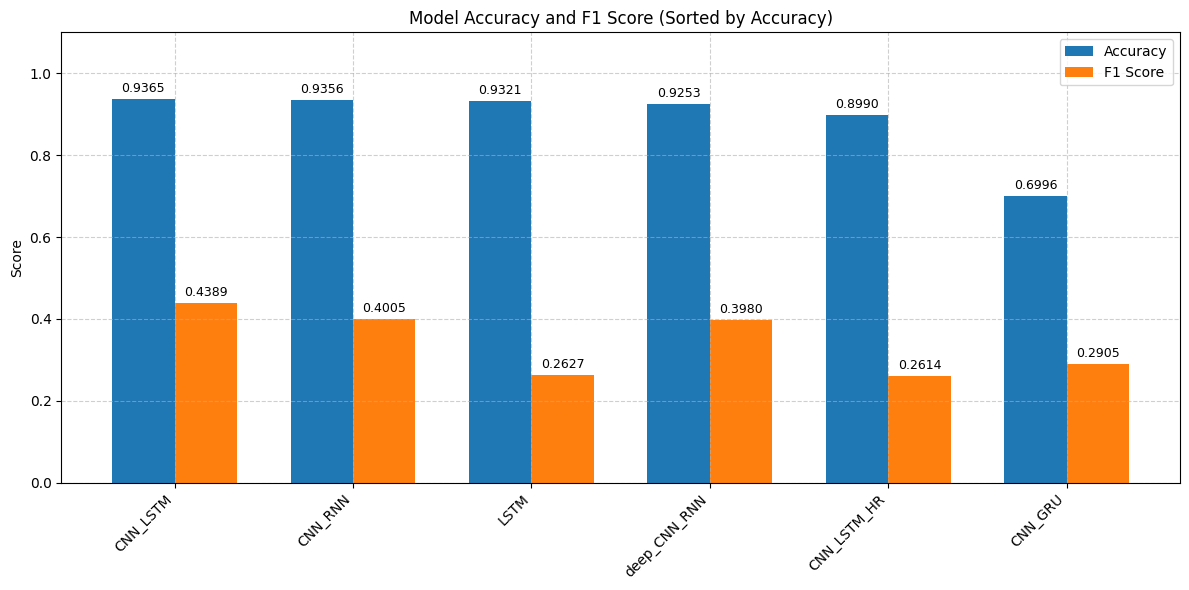

In [22]:
plot_accuracy_f1(compiled_results,model_names)